In [1]:
import os

if not os.path.exists("groundtruth-drosophila-vnc"):
    os.system("git clone https://github.com/unidesigner/groundtruth-drosophila-vnc")

raw_path = os.path.join("groundtruth-drosophila-vnc", "stack1", "raw")
label_path = os.path.join("groundtruth-drosophila-vnc", "stack1", "labels")

train_images_paths = os.listdir(raw_path)

print(f"{len(train_images_paths)} training images")

20 training images


In [2]:
import deeptrack as dt
import torch

dt.config.disable_image_wrapper()

raw_paths = dt.sources.ImageFolder(root=raw_path)
label_paths = dt.sources.ImageFolder(root=label_path)

raw_sources = raw_paths.product(flip_ud=[True, False], flip_lr=[True, False])
label_sources = label_paths.product(flip_ud=[True, False], flip_lr=[True, False])

2024-01-09 14:59:41.667978: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import numpy as np


def select_labels(class_labels=None):
    def inner(gt_seg_image):
        gt_seg_image = gt_seg_image.copy()
        masked_gt_seg_imag = gt_seg_image * np.isin(gt_seg_image, class_labels).astype(
            np.uint8
        )
        replace = np.arange(len(class_labels)) + 1
        gt_seg_image_new_labels = np.select(
            [masked_gt_seg_imag == cl for cl in class_labels], replace
        ).astype(np.uint8)
        out = np.eye(len(class_labels) + 1)[gt_seg_image_new_labels.squeeze()]

        return out  # gt_seg_image_new_labels

    return inner

In [11]:
# benjamin version

im_pipeline = dt.LoadImage(raw_sources.path) >> dt.NormalizeMinMax()
lab_pipeline = dt.LoadImage(label_sources.path) >> dt.Lambda(
    select_labels, class_labels=[255, 191]
)

pipeline = (
    (im_pipeline & lab_pipeline)
    # >> dt.Crop(crop=(256, 256, None))
    >> dt.FlipLR(raw_sources.flip_lr)
    >> dt.FlipUD(raw_sources.flip_ud)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

In [39]:
# my first version
im_pipeline = (
    dt.LoadImage(raw_sources.path)
    # >> dt.Crop(crop=(256, 256, None))
    >> dt.NormalizeMinMax()
    >> dt.FlipLR(raw_sources.flip_lr)
    >> dt.FlipUD(raw_sources.flip_ud)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)


lab_pipeline = (
    dt.LoadImage(label_sources.path)
    # >> dt.Crop(crop=(256, 256, None))
    >> dt.Lambda(select_labels, class_labels=[255, 191])
    >> dt.FlipLR(label_sources.flip_lr)
    >> dt.FlipUD(label_sources.flip_ud)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

pipeline = im_pipeline & lab_pipeline

In [23]:
# pipeline = (
#     pipeline
#     >> dt.Crop(crop=(256, 256, None))
#     >> dt.MoveAxis(2, 0)
#     >> dt.pytorch.ToTensor(dtype=torch.float)
# )

In [15]:
from torch.utils.data import Dataset
from torchvision import transforms


class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, labelPaths, pipeline):
        self.imagePaths = imagePaths
        self.labelPaths = labelPaths
        self.pipeline = pipeline

    def __len__(self):
        return len(self.imagePaths)

    def __getitem__(self, idx):
        image, label = pipeline([self.imagePaths[idx], self.labelPaths[idx]])
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(256, 256))
        image = transforms.functional.crop(image, i, j, h, w)
        label = transforms.functional.crop(label, i, j, h, w)

        return (image, label)

In [16]:
ds = SegmentationDataset(raw_sources, label_sources, pipeline)

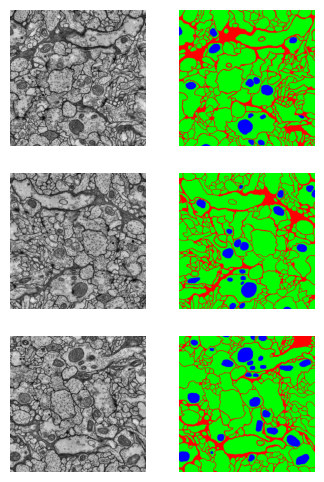

In [18]:
import matplotlib.pyplot as plt
from numpy import squeeze, random


fig, axs = plt.subplots(3, 2, figsize=((4, 6)))
for i, k in enumerate(random.choice(np.linspace(0, 19, 20).astype(int), 3)):
    image, label = pipeline([raw_sources[k], label_sources[k]])
    axs[i, 0].imshow(image.permute(1, 2, 0), cmap="gray")
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(label.permute(1, 2, 0), cmap="gray")
    axs[i, 1].set_axis_off()

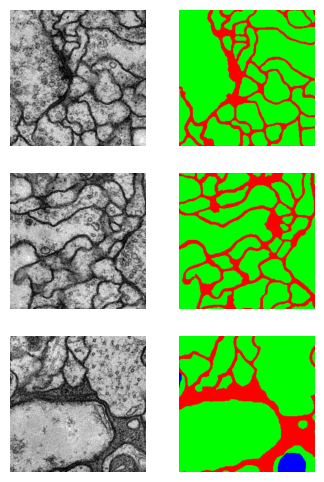

In [21]:
fig, axs = plt.subplots(3, 2, figsize=((4, 6)))
for i, k in enumerate(random.choice(np.linspace(0, 19, 20).astype(int), 3)):
    image, label = ds[k]
    axs[i, 0].imshow(image.permute(1, 2, 0), cmap="gray")
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(label.permute(1, 2, 0), cmap="gray")
    axs[i, 1].set_axis_off()

In [12]:
import deeplay as dl
import torch.nn as nn

dense = dl.MultiLayerPerceptron(
    in_features=5,
    hidden_features=[15],
    out_features=2,
)
rep = dl.Sequential(nn.Identity(), nn.Sigmoid(), nn.Identity())
dense.replace("blocks", rep)
dense = dense.create()
print(dense)

MultiLayerPerceptron(
  (blocks): Sequential(
    (0): Identity()
    (1): Sigmoid()
    (2): Identity()
  )
)


In [18]:
from deeplay import ConvolutionalEncoder2d, Sequential

enc = ConvolutionalEncoder2d(
    in_channels=1,
    channels=[16, 32, 64, 128],
    out_channels=3,
)

import torch.nn as nn

# rep = nn.Sigmoid
# enc.postprocess.configure(rep)
# enc.build()
# print(enc)

rep = Sequential(nn.Identity(), nn.Sigmoid(), nn.Identity())
enc.replace("postprocess", rep)
enc = enc.create()
print(enc)

ConvolutionalEncoder2d(
  (blocks): LayerList(
    (0): PoolLayerActivationNormalization(
      (pool): Identity()
      (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (normalization): Identity()
    )
    (1): PoolLayerActivationNormalization(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (normalization): Identity()
    )
    (2): PoolLayerActivationNormalization(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (normalization): Identity()
    )
    (3): PoolLayerActivationNormalization(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (layer): Conv2d(64, 128, kernel_size=(3,

In [16]:
enc.postprocess

Sequential(
  (0): Identity()
  (1): Sigmoid()
  (2): Identity()
)

In [17]:
import deeplay as dl
from torch.nn import Softmax2d, Identity, Sigmoid

unet = dl.UNet2d(in_channels=1, channels=[16, 32, 64, 128], out_channels=3)
unet.skip.configure(Identity())
print(unet)

AttributeError: 'concat' object has no attribute 'configure'

In [15]:
unet.replace("skip", Identity).build()

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (1): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (2): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (3): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [5]:
import torchmetrics as tm
from torch.nn import CrossEntropyLoss, L1Loss


unet_regressor = dl.Regressor(
    model=unet,
    loss=CrossEntropyLoss(),  # loss=L1Loss(),  #
    optimizer=dl.Adam(),
).create()

In [ ]:
from torch.utils.data import DataLoader

data_loader = DataLoader(ds, batch_size=8, shuffle=True)

In [ ]:
unet_trainer = dl.Trainer(max_epochs=100, accelerator="auto")

unet_trainer.fit(unet_regressor, data_loader)

In [ ]:
image, label = pipeline([raw_sources[k], label_sources[k]])
pred = unet_regressor(image.unsqueeze(0)).detach().squeeze()

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=((4, 4)))
for i in range(2):
    axs[i, 0].imshow(image.permute(1, 2, 0), cmap="gray")
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(label.permute(1, 2, 0).numpy().argmax(axis=2))
    axs[i, 1].set_axis_off()
    axs[i, 2].imshow(pred.permute(1, 2, 0).numpy().argmax(axis=2))
    axs[i, 2].set_axis_off()

In [ ]:
t = pred.permute(1, 2, 0).numpy().argmax(axis=2)

In [ ]:
pred[0, 10, 10]

In [ ]:
s = pred.permute(1, 2, 0).numpy()

In [ ]:
s.shape

In [ ]:
from deeptrack.models import unet

In [ ]:
model = unet()
model.summary()